# Machine Learning : Projet de Classification

### Importation des librairies

In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Lecture des fichiers de données CSV

In [156]:
trainData = pd.read_csv('data/HAI817_Projet_train.csv') # ID, text, title, rating
testData = pd.read_csv('data/HAI817_Projet_test.csv') # ID, text, title, rating

### Tokenization

In [157]:
import nltk
from nltk.corpus import stopwords
from string import punctuation

nltk.download('punkt')
nltk.download('stopwords')

def tokenizeData(data):
    tokens = nltk.word_tokenize(data)

    tokens = [token for token in tokens if token not in punctuation]
    tokens = [token for token in tokens if token.lower() not in set(stopwords.words('english'))]

    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Valentin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Valentin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Filtrage des données

In [166]:
from sklearn.utils import resample

positiveClass = trainData[trainData['our rating'] == 'true']
negativeClass = trainData[trainData['our rating'] == 'false']

if (len(negativeClass) > len(positiveClass)):
    negativeClass = resample(negativeClass, replace=False, n_samples=len(positiveClass))
else:
    positiveClass = resample(positiveClass, replace=False, n_samples=len(negativeClass))

filteredTrainData = pd.concat([negativeClass, positiveClass]).sample(frac=1)

filteredTestData = testData[testData['our rating'].isin(['true', 'false'])]

def concatenateTitleAndText(row):
    title = row['title']
    text = row['text']

    if pd.isna(title):
        title = ''
    
    if pd.isna(text):
        text = ''

    return str(title) + ' ' + str(text)

### Classification

In [167]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

print("Création de la pipeline...")

pipeline = Pipeline([
    ('bow', CountVectorizer(tokenizer=tokenizeData)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

xTrainData = filteredTrainData.apply(concatenateTitleAndText, axis=1)
yTrainData = filteredTrainData['our rating']

xTestData = filteredTestData.apply(concatenateTitleAndText, axis=1)
yTestData = filteredTestData['our rating']

print("Entraînement...")

pipeline.fit(xTrainData.values, yTrainData)

print("Prédiction...")

predicted = pipeline.predict(xTestData.values)

print("Prédiction des probabilités...")

predictedProbas = pipeline.predict_proba(xTestData.values)

Création de la pipeline...
Entraînement...


c:\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Prédiction...
Prédiction des probabilités...


### Évaluation des résultats

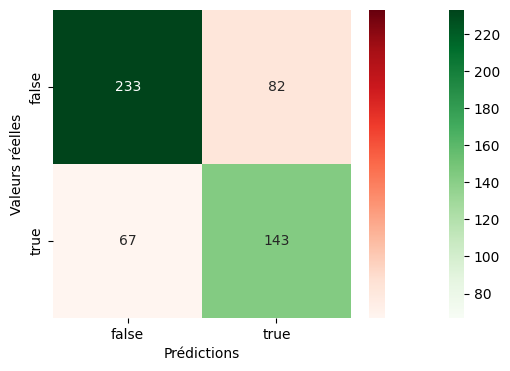

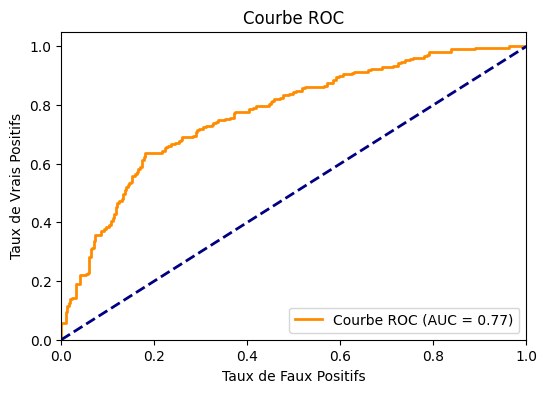

Accuracy : 0.7161904761904762
Précision : 0.7202222222222222
Rappel : 0.7161904761904762
F-mesure : 0.7176226520885899


In [171]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

testLabels = filteredTestData['our rating']

confusionMatrix = confusion_matrix(testLabels, predicted)

vmin = np.min(confusionMatrix)
vmax = np.max(confusionMatrix)

diagonal = np.eye(*confusionMatrix.shape, dtype=bool)

learningClasses = pipeline.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(confusionMatrix, annot=True, fmt="d", mask=~diagonal, cmap='Greens', vmin=vmin, vmax=vmax, xticklabels=learningClasses, yticklabels=learningClasses)
sns.heatmap(confusionMatrix, annot=True, fmt="d", mask=diagonal, cmap='Reds', vmin=vmin, vmax=vmax, xticklabels=learningClasses, yticklabels=learningClasses, cbar_kws=dict(ticks=[]))
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

yTestDataResults = (yTestData == 'true').astype(int)
fpr, tpr, thresholds = roc_curve(yTestDataResults, predictedProbas[:, 1])

rocAuc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % rocAuc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

label_encoder = LabelEncoder()
predictedEncoded = label_encoder.fit_transform(predicted)

print("Exactitude :", accuracy_score(yTestDataResults, predictedEncoded))
print("Précision :", precision_score(yTestDataResults, predictedEncoded, average='weighted'))
print("Rappel :", recall_score(yTestDataResults, predictedEncoded, average='weighted'))
print("F-mesure :", f1_score(yTestDataResults, predictedEncoded, average='weighted'))